# Tau trigger BDT notebook

### Standard import

In [9]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump,load
import time
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc
import scipy
reversetraining=False

print("Versions ", sklearn.__version__, np.__version__, scipy.__version__)

Versions  0.21.2 1.14.2 1.3.0


In [10]:
! ls -lhtr /eos/user/a/adsalvad/Hplnn/
! ls -lhtr
#import root_pandas

total 109M
-rw-r--r--. 1 adsalvad 1307 49M Mar 18 16:29 pandas_INC_ge6jge4b.h5
-rw-r--r--. 1 adsalvad 1307 61M Jun 25 17:51 trigger_test.h5
total 622M
-rw-r--r--. 1 adsalvad 1307 291M Jun 26 13:48 pandas_trigger.h5
-rw-r--r--. 1 adsalvad 1307  474 Jun 26 13:48 setup.sh
-rw-r--r--. 1 adsalvad 1307 1.5K Jun 26 23:22 TMVAplots.py
drwxr-xr-x. 2 adsalvad 1307 4.0K Jun 26 23:28 __pycache__
-rw-r--r--. 1 adsalvad 1307 1.3K Jun 27 11:58 README.md
-rw-r--r--. 1 adsalvad 1307 107K Jul  4 07:05 BDTtest.ipynb
-rw-r--r--. 1 adsalvad 1307  902 Jul  5 22:14 optimiseweightAUC.txt~
-rw-r--r--. 1 adsalvad 1307  22K Jul  5 23:39 HpHyperParameterOptimisation.py
-rw-r--r--. 1 adsalvad 1307  16K Jul  6 02:01 optimiseweight.txt~
-rw-r--r--. 1 adsalvad 1307 2.5K Jul  6 12:45 optimiseweight.txt
-rw-r--r--. 1 adsalvad 1307 1.8K Jul  6 12:48 optimiseweightAUC.txt
-rw-r--r--. 1 adsalvad 1307 391K Jul  7 18:12 TauTriggerBDT.ipynb
-rw-r--r--. 1 adsalvad 1307 5.1K Jul  8 03:24 optimiseweight_goodq.txt
-rw-r--r--. 1 

### Read the pandas file

In [11]:
df_mc = pd.read_hdf('pandas_trigger_new.h5')
df_mc["Weight"] = 1.0 #keep it flexible
#the file can be written in lots of different ways, and including samples and other info accessible with keys

### Check events

In [12]:
df_mc.head()

EventNumber  Coretrack_signalv8  Coretrack_z0  Coretrack_nSiHoles  \
0     60000393                   1    -13.694421                   0   
1     60000393                  -1   -100.047989                   0   
2     60000393                  -1    -62.319122                   1   
3     60000393                  -1    -97.825089                   2   
4     60000393                   0    179.047913                   2   

   Coretrack_nPiHits  Coretrack_pt  Coretrack_CaloHadpt  Coretrack_signalv1  \
0                  5  26539.250000         14245.416992                   1   
1                  1    774.340820            -1.000000                  -1   
2                  5    555.448608            -1.000000                  -1   
3                  2   1123.344360            -1.000000                  -1   
4                  2   1149.612915         14245.416992                   0   

   Coretrack_CaloEMpt  Coretrack_d0  Coretrack_dRleadtrk  Coretrack_dR  \
0         3295.686768      0.014015             0.000000      0.012274   
1           -1.000000     14.720797            -1.000000     -1.000000   
2           -1.000000    -10.068580            -1.000000     -1.000000   
3           -1.000000     -1.563127            -1.000000     -1.000000   
4         3295.686768      0.976296             0.096081      0.095885   

   Coretrack_ratioptCalo  __array_index  Weight  
0               0.910458              0     1.0  
1              -1.000000              1     1.0  
2              -1.000000              2     1.0  
3              -1.000000              3     1.0  
4               0.039439              4     1.0

### Some definitions

In [13]:
features_names = ["Coretrack_pt","Coretrack_dRleadtrk"]

### Prepare sample for splitting

In [14]:
df_mc=df_mc[df_mc.Coretrack_signalv8!=-1] #keep selected entries for the training
df_mc.reset_index(inplace = True, drop = True) #resseting index here 
df_mc.head(1)

EventNumber  Coretrack_signalv8  Coretrack_z0  Coretrack_nSiHoles  \
0     60000393                   1    -13.694421                   0   

   Coretrack_nPiHits  Coretrack_pt  Coretrack_CaloHadpt  Coretrack_signalv1  \
0                  5      26539.25         14245.416992                   1   

   Coretrack_CaloEMpt  Coretrack_d0  Coretrack_dRleadtrk  Coretrack_dR  \
0         3295.686768      0.014015                  0.0      0.012274   

   Coretrack_ratioptCalo  __array_index  Weight  
0               0.910458              0     1.0

In [15]:
nbkg=df_mc[df_mc.Coretrack_signalv8==0].shape[0]
nsignal=df_mc[df_mc.Coretrack_signalv8==1].shape[0]
print('ratio signal/bkg: ',nsignal/nbkg , " (",nsignal,"/",nbkg,")")
print('signal ratio', nsignal/(nbkg+nsignal))

ratio signal/bkg:  0.4016427994447538  ( 409711 / 1020088 )
signal ratio 0.28655146632498696


In [16]:
from sklearn.utils import shuffle
random_state = 123456789
df_mc = shuffle(df_mc,random_state = random_state)
df_mc["Coretrack_z0"]=df_mc["Coretrack_z0"].apply(abs)
df_mc["Coretrack_d0"]=df_mc["Coretrack_d0"].apply(abs)
df_mc["Coretrack_pt"]=df_mc["Coretrack_pt"].apply(np.log)
df_mc["Coretrack_ratioptCalo"]=df_mc["Coretrack_ratioptCalo"].apply(np.log)
#df_mc["Coretrack_CaloEMpt"]=df_mc["Coretrack_CaloEMpt"].apply(np.log)
#df_mc["Coretrack_CaloHadpt"]=df_mc["Coretrack_CaloHadpt"].apply(np.log)

#df_even = df_mc[df_mc.EventNumber%2==0]
#df_odd = df_mc[df_mc.EventNumber%2==1]
if reversetraining:
    df_even = df_mc[df_mc.EventNumber%2==1]
    df_odd = df_mc[df_mc.EventNumber%2==0]
else:
    df_even = df_mc[df_mc.EventNumber%2==0]
    df_odd = df_mc[df_mc.EventNumber%2==1]

In [17]:
def getxyw(df,features,ycolumn):
    X = df.loc[:,features].copy()
    y = df[ycolumn].copy()
    w = df["Weight"].copy()
    #for obj in [X,y,w]: obj.reset_index(inplace = True, drop = True) reset index
    return X, y, w
X_train, y_train, w_train = getxyw(df_even,features_names,"Coretrack_signalv8")
X_test, y_test, w_test = getxyw(df_odd,features_names,"Coretrack_signalv8")
print ("even:", w_train[y_train==1].sum()/w_train[y_train==0].sum() ,w_train[y_train==1].sum()/(w_train[y_train==0].sum()+w_train[y_train==1].sum()) )
print ("odd:", w_test[y_test==1].sum()/w_test[y_test==0].sum() ,w_test[y_test==1].sum()/(w_test[y_test==0].sum()+w_test[y_test==1].sum()) )
df_mc.head()

even: 0.4015092533941532 0.286483483731402
odd: 0.4017762811001104 0.28661940319378026


EventNumber  Coretrack_signalv8  Coretrack_z0  Coretrack_nSiHoles  \
1003585     61021806                   0     58.303303                   1   
899554      60818022                   0     61.826046                   1   
600238      60580423                   1     16.621363                   0   
1062171     61442954                   0     50.333900                   5   
1011795     61179519                   0    219.223923                   3   

         Coretrack_nPiHits  Coretrack_pt  Coretrack_CaloHadpt  \
1003585                  2      7.075783         42901.285156   
899554                   1      6.944490         34070.820312   
600238                   5     10.202984         12673.310547   
1062171                  2      7.535610         34710.937500   
1011795                  2      7.900557           922.375916   

         Coretrack_signalv1  Coretrack_CaloEMpt  Coretrack_d0  \
1003585                   0        18601.738281      0.009391   
899554                    0        29346.822266      7.003039   
600238                    1        15378.499023      0.175403   
1062171                   0        42444.894531      0.433980   
1011795                   0        35267.164062      0.502215   

         Coretrack_dRleadtrk  Coretrack_dR  Coretrack_ratioptCalo  \
1003585             0.072082      0.082525              -4.259779   
899554              0.107464      0.114692              -4.305910   
600238              0.000000      0.026888              -0.324974   
1062171             0.094440      0.101213              -4.047593   
1011795             0.145573      0.102574              -2.667933   

         __array_index  Weight  
1003585             16     1.0  
899554              27     1.0  
600238               0     1.0  
1062171             15     1.0  
1011795              7     1.0

In [18]:
X_train.head() # you can check if its working or not

Coretrack_pt  Coretrack_dRleadtrk
1003585      7.075783             0.072082
899554       6.944490             0.107464
1062171      7.535610             0.094440
212839       8.757286             0.080462
1084463     11.475793             0.000000

In [19]:
X_train[:1].values

array([[7.075783  , 0.07208199]], dtype=float32)

### Weight transformer

In [20]:
signalratio=0.55
for label,ratio in zip([0,1],[1.-signalratio,signalratio]):
    print("-->bkg" if label==0 else "--> signal")
    sumweight = w_train[y_train==label].sum()
    print("sumweight",sumweight,end='')
    wscale=ratio/sumweight
    print(", scale", wscale,end="")
    w_train[y_train==label]*=wscale
    print("newsumweight:",w_train[y_train==label].sum())
print("Totalweight:", w_train.sum())

-->bkg
sumweight 509921.0, scale 8.824896405521639e-07newsumweight: 0.45000000000000034
--> signal
sumweight 204738.0, scale 2.686360128554543e-06newsumweight: 0.5499999999999999
Totalweight: 0.9999999999999997


### Get BDT and training it

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
def getBDT(options={}):
    """ Standard BDT classifier based on GradienBoosting"""
    bdt = GradientBoostingClassifier(n_estimators=100,
                                    learning_rate=0.2,
                                    max_depth=6,
                                    min_weight_fraction_leaf=0.01,
                                    random_state=0)
    bdt.set_params(**options)
    return bdt

In [22]:
#classifier = getBDT(options={"n_iter_no_change":15})
classifier = getBDT()

In [15]:
!date
classifier.fit(X_train,y_train, sample_weight = w_train)
!date
print("Trees used",classifier.n_estimators_) 
#159 without variables
#136 with variables
#137 wih log variables (no 0 or negative EM/Calo)
#118 with variables, d6w55

Mon Jul 29 13:53:58 CEST 2019
Mon Jul 29 13:55:41 CEST 2019
Trees used 100


### Some validation

In [16]:
classifier

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.01, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [24]:
test = 1.-roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1], sample_weight = w_test)
train = 1.-roc_auc_score(y_train,classifier.predict_proba(X_train)[:,1], sample_weight = w_train)
print (1.-test, 1.-train)
#0.9991505549408224 0.9992831009239904 without variables
#0.99953584890731 0.9996240058366015 with variables
#0.9995497248203019 0.9996487184177444 wih log variables (no 0 or negative EM/Calo)
#0.9995492576748856 0.9996509113630888 with w55d6
#0.9995256857046503 0.9996716742869963 reversed

ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 2 

In [18]:
for feature, importance in reversed(sorted(zip(features_names,classifier.feature_importances_),key=lambda x: x[1])):
    print(feature,"\t", importance)

Coretrack_dRleadtrk 	 0.9273723067102257
Coretrack_pt 	 0.07262769328977421


In [19]:
classifier.predict_proba(X_test)


array([[0.0129701 , 0.9870299 ],
       [0.92152966, 0.07847034],
       [0.99724587, 0.00275413],
       ...,
       [0.67175314, 0.32824686],
       [0.01873508, 0.98126492],
       [0.01301578, 0.98698422]])

1.0

In [19]:
print(test, train) #abs/ln, signal weight 0.6
print((0.598/0.591817876)*100)

0.00046415109269004606 0.00037599416339850755
101.04459906513537


### Save BDT and training

In [18]:
if reversetraining:
    dump(classifier,"models/BDT_t250l2d6_w55_train2mod1.sav")
else:
    dump(classifier,"models/BDT_t250l2d6_w55_train2mod0.sav")


['models/BDT_t250l2d6_w55_train2mod0.sav']

In [23]:
if reversetraining:
    classifier = load("models/BDT_t250l2d6_w55_train2mod1.sav")
else:
    classifier = load("models/BDT_t250l2d6_w55_train2mod0.sav")

In [32]:
testclass=load("models/BDT_t250l02d5_w06.sav")

In [20]:
classifier.predict_proba([[ 7.07578278e+00,  5.83033028e+01,  9.39120445e-03,
         2.00000000e+00,  1.00000000e+00, -4.25977898e+00,
         8.25245231e-02,  7.20819905e-02,  4.29012852e+04,
         1.86017383e+04]])

array([[9.99925328e-01, 7.46718491e-05]])

In [21]:
test2 = 1.-roc_auc_score(y_test,testclass.predict_proba(X_test)[:,1], sample_weight = w_test)
train2 = 1.-roc_auc_score(y_train,testclass.predict_proba(X_train)[:,1], sample_weight = w_train)
test2,train2,roc_auc_score(y_test,testclass.predict_proba(X_test)[:,1], sample_weight = w_test)

NameError: name 'testclass' is not defined

### ROC curve and BDT score a la TMVA

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1], sample_weight = w_test )
roc_auc = auc(fpr,tpr,reorder=True)
print(roc_auc, 1.-roc_auc)

0.9995492576748856 0.00045074232511443935


/eos/user/a/adsalvad/python_pipJuly/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


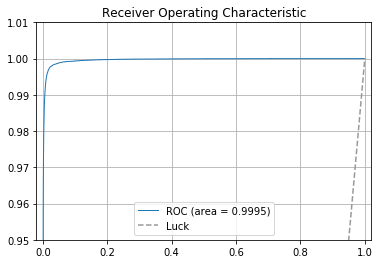

In [17]:
plt.plot(fpr,tpr,lw=1, label='ROC (area = %0.4f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.02, 1.02])
plt.ylim([0.95, 1.01])
plt.title('Receiver Operating Characteristic')
plt.legend(loc="best")
plt.grid()

In [26]:
def decfunc2TMVA(clf, X):
    bdtdf=(clf.decision_function(X)[:]-clf._init_decision_function(X)[:,0])/bdt.get_params()['learning_rate']
    return 2/(1+np.exp(-2*bdtdf))-1

In [8]:
bins = 50
decisions = []
for X,y in ((X_train, y_train), (X_test, y_test)):
    #d1 = 1.+np.exp(classifier.decision_function(X[y>0.5]).ravel())
    #d2 = 1.+np.exp(classifier.decision_function(X[y<0.5]).ravel())
    #d1 = 1./d1
    #d2 = 1./d2
    #d1 = decfunc2TMVA(classifier,X[y>0.5])
    #d2 = decfunc2TMVA(classifier,X[y<0.5])
    d1 = classifier.predict_proba(X[y>0.5])[:,1]
    d2 = classifier.predict_proba(X[y<0.5])[:,1]
    decisions += [d1, d2]
        
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low,high)
plt.figure(figsize=(8,6))
plt.hist(decisions[0],
        color='b', alpha=0.5, range=low_high, bins=bins,
        histtype='stepfilled', normed=True,
        label='S (train)')
plt.hist(decisions[1],
        color='r', alpha=0.5, range=low_high, bins=bins,
        histtype='stepfilled', normed=True,
        label='B (train)')

hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, normed=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
   
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S (test)')
    
hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, normed=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='B (test)')

plt.xlabel("BDT output",horizontalalignment='right',x=1)
#plt.ylim([0,0.4])
#plt.ylabel("Arbitrary units")
#plt.yscale('log')
plt.legend(loc='best')
#plt.grid()
plt.show()

NameError: name 'X_train' is not defined

/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


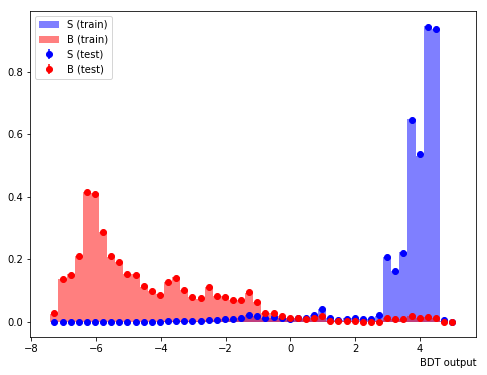

In [32]:
bins = 50
decisions = []
for X,y in ((X_train, y_train), (X_test, y_test)):
    d1 = classifier.decision_function(X[y>0.5]).ravel()
    d2 = classifier.decision_function(X[y<0.5]).ravel()
    decisions += [d1, d2]
        
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low,high)
plt.figure(figsize=(8,6))
plt.hist(decisions[0],
        color='b', alpha=0.5, range=low_high, bins=bins,
        histtype='stepfilled', normed=True,
        label='S (train)')
plt.hist(decisions[1],
        color='r', alpha=0.5, range=low_high, bins=bins,
        histtype='stepfilled', normed=True,
        label='B (train)')

hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, normed=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
   
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S (test)')
    
hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, normed=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='B (test)')

plt.xlabel("BDT output",horizontalalignment='right',x=1)
#plt.ylim([0,0.4])
#plt.ylabel("Arbitrary units")
#plt.yscale('log')
plt.legend(loc='best')
#plt.grid()
plt.show()

## Test root conversion

In [39]:
import sys
sys.path.append("../HplusML/koza4ok")

In [27]:
!ls ../HplusML/koza4ok

examples  LICENSE  mva_tools  README.md  setup_koza4ok.sh  skTMVA  test


In [40]:
from skTMVA import convert_bdt_sklearn_tmva

In [36]:
features_names

['Coretrack_pt', 'Coretrack_dRleadtrk']

In [43]:
convert_bdt_sklearn_tmva(classifier,[("Coretrack_pt","F"),("Coretrack_dRleadtrk","F")],'bdt.xml')
!ls

BDTtest.ipynb			 pandas_trigger.h5
bdt.xml				 pandas_trigger_new.h5
createHDF.py			 __pycache__
fromusatlas			 README.md
HpHyperParameterOptimisation.py  results
models				 setup.sh
optimiseweightAUC.txt		 TauTriggerBDT-GoodQuality.ipynb
optimiseweightAUC.txt~		 TauTriggerBDT.ipynb
optimiseweight_goodq.txt	 TauTriggerBDT-newvariable.ipynb
optimiseweight_newvar.txt	 TauTriggerBDT-newvariable-toTMVA.ipynb
optimiseweight.txt		 TMVAplots.py
optimiseweight.txt~


In [44]:
import ROOT
from ROOT import TFile, TMVA
import array

Welcome to JupyROOT 6.16/00


In [51]:
reader=TMVA.Reader("silent")
variables={}
for name in features_names:
    variables[name] = array.array('f',[0])
    reader.AddVariable(name,variables[name])

reader.BookMVA('BDTtest','bdt.xml')


for ievt in range(0,10):
    variables['Coretrack_pt'][0]=X_train.values[ievt,0]
    variables['Coretrack_dRleadtrk'][0]=X_train.values[ievt,1]
    print(reader.EvaluateMVA('BDTtest'), y_train.values[ievt])

-1.0 0
-1.0 0
-1.0 0
-0.9999999272238516 0
1.0 1
-1.0 0
-1.0 0
-0.9982948797529151 0
-1.0 0
-1.0 0


In [71]:
X_train.values[:5]
classifier.predict_proba(X_train[:10])[:,1]

array([0.00225243, 0.00169039, 0.0060904 , 0.18060828, 0.98240747,
       0.00997344, 0.00249949, 0.37613856, 0.00876394, 0.00206928])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.01, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
bdtdf=(classifier.decision_function(X_train[:10]).ravel())/classifier.get_params()['learning_rate']
2/(1+np.exp(-2*bdtdf))-1

ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 2 

In [ ]:
classifier = load("models/BDT_t250l2d6_w55_train2mod0.sav")

# Optimisation things

### Optimise weights

In [15]:
with open("optimiseweight_newvar.txt",'w+') as outfile:
    outfile.write("Ratio\ttest 1-AUC\t\ttrain 1-AUC\n")
    for signalratio in np.arange(0.1,0.91,0.01):
        print ("Trying ratio:",signalratio)
        for label,ratio in zip([0,1],[1.-signalratio,signalratio]):
            print("-->bkg" if label==0 else "--> signal")
            sumweight = w_train[y_train==label].sum()
            print("sumweight",sumweight,end='')
            wscale=ratio/sumweight
            print(", scale", wscale,end="")
            w_train[y_train==label]*=wscale
            print("newsumweight:",w_train[y_train==label].sum())
        print("Totalweight:", w_train.sum())
        !date
        classifier.fit(X_train,y_train, sample_weight = w_train)
        !date
        test = 1.-roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1], sample_weight = w_test)
        train = 1.-roc_auc_score(y_train,classifier.predict_proba(X_train)[:,1], sample_weight = w_train)
        print("For",signalratio,test,train)
        outfile.write(str(signalratio)+"\t"+str(test)+"\t"+str(train)+"\n")

Trying ratio: 0.1
-->bkg
sumweight 0.3999999999999997, scale 2.2500000000000018newsumweight: 0.9000000000000011
--> signal
sumweight 0.5999999999999999, scale 0.1666666666666667newsumweight: 0.1
Totalweight: 1.0000000000000009
Mon Jul 22 23:20:03 CEST 2019
Mon Jul 22 23:24:49 CEST 2019
For 0.1 0.00047575959564860604 0.0004164933316882502
Trying ratio: 0.11
-->bkg
sumweight 0.9000000000000011, scale 0.9888888888888877newsumweight: 0.8900000000000002
--> signal
sumweight 0.1, scale 1.0999999999999999newsumweight: 0.10999999999999997
Totalweight: 0.9999999999999993
Mon Jul 22 23:24:55 CEST 2019
Mon Jul 22 23:29:25 CEST 2019
For 0.11 0.00047510495570834976 0.00040821964587989257
Trying ratio: 0.12
-->bkg
sumweight 0.8900000000000002, scale 0.98876404494382newsumweight: 0.879999999999999
--> signal
sumweight 0.10999999999999997, scale 1.090909090909091newsumweight: 0.12000000000000004
Totalweight: 0.9999999999999991
Mon Jul 22 23:29:31 CEST 2019
Mon Jul 22 23:33:35 CEST 2019
For 0.12 0.0004

Tue Jul 23 01:08:28 CEST 2019
Tue Jul 23 01:13:23 CEST 2019
For 0.3199999999999999 0.00044964161752014675 0.00036228961185902353
Trying ratio: 0.32999999999999985
-->bkg
sumweight 0.6800000000000008, scale 0.9852941176470579newsumweight: 0.6700000000000004
--> signal
sumweight 0.32, scale 1.0312499999999996newsumweight: 0.32999999999999985
Totalweight: 0.9999999999999989
Tue Jul 23 01:13:29 CEST 2019
Tue Jul 23 01:18:53 CEST 2019
For 0.32999999999999985 0.0004544285955792038 0.00035020620654235834
Trying ratio: 0.33999999999999986
-->bkg
sumweight 0.6700000000000004, scale 0.9850746268656713newsumweight: 0.6599999999999993
--> signal
sumweight 0.32999999999999985, scale 1.0303030303030303newsumweight: 0.33999999999999975
Totalweight: 0.9999999999999988
Tue Jul 23 01:18:59 CEST 2019
Tue Jul 23 01:23:53 CEST 2019
For 0.33999999999999986 0.00045932470101472944 0.0003607219616845736
Trying ratio: 0.34999999999999987
-->bkg
sumweight 0.6599999999999993, scale 0.9848484848484862newsumweight:

sumweight 0.5299999999999996, scale 1.0188679245283023newsumweight: 0.54
Totalweight: 1.000000000000001
Tue Jul 23 02:53:46 CEST 2019
Tue Jul 23 02:59:19 CEST 2019
For 0.5399999999999998 0.0004542471867958753 0.00035155109373707916
Trying ratio: 0.5499999999999998
-->bkg
sumweight 0.46000000000000046, scale 0.9782608695652167newsumweight: 0.45000000000000107
--> signal
sumweight 0.54, scale 1.0185185185185182newsumweight: 0.5499999999999997
Totalweight: 1.0000000000000004
Tue Jul 23 02:59:25 CEST 2019
Tue Jul 23 03:04:23 CEST 2019
For 0.5499999999999998 0.00044906469073102695 0.00035221940181551226
Trying ratio: 0.5599999999999997
-->bkg
sumweight 0.45000000000000107, scale 0.9777777777777761newsumweight: 0.4399999999999995
--> signal
sumweight 0.5499999999999997, scale 1.0181818181818183newsumweight: 0.5599999999999995
Totalweight: 0.9999999999999993
Tue Jul 23 03:04:29 CEST 2019
Tue Jul 23 03:09:04 CEST 2019
For 0.5599999999999997 0.0004544753152739833 0.0003631499885072831
Trying ra

Tue Jul 23 04:32:40 CEST 2019
Tue Jul 23 04:36:44 CEST 2019
For 0.7599999999999997 0.0004788039257445087 0.00038452918969245076
Trying ratio: 0.7699999999999997
-->bkg
sumweight 0.24000000000000032, scale 0.9583333333333334newsumweight: 0.23000000000000032
--> signal
sumweight 0.7599999999999999, scale 1.0131578947368418newsumweight: 0.7699999999999992
Totalweight: 1.0000000000000002
Tue Jul 23 04:36:49 CEST 2019
Tue Jul 23 04:40:28 CEST 2019
For 0.7699999999999997 0.0004894021003609694 0.0004041232363294345
Trying ratio: 0.7799999999999997
-->bkg
sumweight 0.23000000000000032, scale 0.9565217391304348newsumweight: 0.2200000000000002
--> signal
sumweight 0.7699999999999992, scale 1.0129870129870135newsumweight: 0.7800000000000004
Totalweight: 1.0000000000000002
Tue Jul 23 04:40:33 CEST 2019
Tue Jul 23 04:44:21 CEST 2019
For 0.7799999999999997 0.00048430153469924964 0.0003931220032092897
Trying ratio: 0.7899999999999996
-->bkg
sumweight 0.2200000000000002, scale 0.9545454545454556newsum

0.09 test
0.09999999999999999 0.00047575959564860604
0.10999999999999999 0.00047510495570834976
0.11999999999999998 0.0004773347967068631
0.12999999999999998 0.0004592000004068897
0.13999999999999996 0.0004667539644640506
0.14999999999999997 0.00046278371322816536
0.15999999999999998 0.0004615325281478455
0.16999999999999996 0.00045917791960137233
0.17999999999999994 0.0004528996791026696
0.18999999999999995 0.00046613682555407543
0.19999999999999996 0.0004648388729643349
0.20999999999999994 0.00046390618605107736
0.21999999999999995 0.0004620496866239998
0.22999999999999993 0.00046829535578274406
0.2399999999999999 0.00045278969106266054
0.24999999999999992 0.0004527437029320236
0.2599999999999999 0.0004618049138661595
0.2699999999999999 0.0004483341354706294
0.2799999999999999 0.0004593075738069663
0.2899999999999999 0.0004682187375870672
0.29999999999999993 0.0004610147576442625
0.3099999999999999 0.00046639738192777447
0.31999999999999984 0.00044964161752014675
0.32999999999999985 

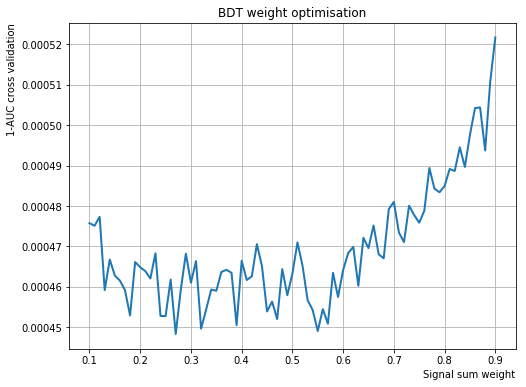

In [21]:
import numpy.polynomial.polynomial as poly
aucs=[]
wpoints=np.arange(0.09,0.91,0.01)
i = 0
with open('optimiseweight_newvar.txt','r') as infile:
    for preline in infile:
        aucs.append(preline.split()[1])
        print(wpoints[i],preline.split()[1])
        i+=1
aucs=aucs[1:]
wpoints = wpoints[1:]
aucs = [float(x) for x in aucs]
wpoints=np.arange(0.1,0.91,0.01)
print(len(wpoints),len(aucs))
coefs = poly.polyfit(wpoints,aucs,2)
x_new=np.arange(0.1,0.901,0.001)
ffit = poly.polyval(x_new, coefs)

min_y = min(ffit)  # Find the maximum y value
min_x = x_new[ffit.argmin()]  # Find the x value corresponding to the maximum y value
print (min_x, min_y)


plt.figure(figsize=(8,6))
plt.plot(wpoints,aucs,lw=2)
#plt.plot(x_new, ffit,label='Polinomial Fit')
axes = plt.gca()
#plt.plot([min(wpoints), max(wpoints)], [min(aucs), max(aucs)], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.ylim(axes.get_ylim())
plt.xlim(axes.get_xlim())
#plt.plot([min_x,min_x],[axes.get_ylim()[0], min_y], '--', color=(0.6, 0.6, 0.6))
#plt.plot([axes.get_xlim()[0],min_x],[min_y, min_y], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([0.0008, 0.00091])
print(min(aucs), max(aucs))
#plt.ylim([0.0008, 0.0010])
plt.title('BDT weight optimisation')
plt.xlabel('Signal sum weight',horizontalalignment='right',x=1)
plt.ylabel('1-AUC cross validation',horizontalalignment='right',y=1)
#plt.legend()
plt.grid()
print(axes.get_ylim())
plt.show()


### Learning curve

In [16]:
def scaleweight(w_train,y_train):
    signalratio=0.55
    for label,ratio in zip([0,1],[1.-signalratio,signalratio]):
        print("-->bkg" if label==0 else "--> signal")
        sumweight = w_train[y_train==label].sum()
        print("sumweight",sumweight,end='')
        wscale=ratio/sumweight
        print(", scale", wscale,end="")
        w_train[y_train==label]*=wscale
        print("newsumweight:",w_train[y_train==label].sum())
    print("Totalweight:", w_train.sum())
    return w_train

In [93]:
print(X_train.shape)
print(0.5*X_train.shape[0])
print(X_train[:int(0.5*X_train.shape[0])].shape)


(714659, 8)
357329.5
(357329, 8)


In [56]:
trainpoints = np.linspace(0.1,1.0,10)
learningcurveAUCs = {}
learningcurveAUCs["train"]=[]
learningcurveAUCs["test"]=[]
for trainpoint in trainpoints:
    print("Original size",df_mc.shape[0], "target size",df_mc.shape[0]*trainpoint)
    print(df_mc[:int(trainpoint*df_mc.shape[0])].shape)
    dfr_mc=df_mc[:int(trainpoint*df_mc.shape[0])].copy()
    dfr_even = dfr_mc[dfr_mc.EventNumber%2==0]
    dfr_odd = dfr_mc[dfr_mc.EventNumber%2==1]
    Xr_train, yr_train, wr_train = getxyw(dfr_even,features_names,"Coretrack_signalv8")
    Xr_test,yr_test,wr_test = getxyw(dfr_odd,features_names,"Coretrack_signalv8")
    wr_train = scaleweight(wr_train,yr_train)
    lc_clf = getBDT(options={"n_iter_no_change":15})
    print("Starting",trainpoint,time.ctime(),end="")
    lc_clf.fit(Xr_train,yr_train, sample_weight = wr_train)
    print("-->",time.ctime())

    test = 1.-roc_auc_score(yr_test,lc_clf.predict_proba(Xr_test)[:,1], sample_weight = wr_test)
    train = 1.-roc_auc_score(yr_train,lc_clf.predict_proba(Xr_train)[:,1], sample_weight = wr_train)
    print(test,train)
    learningcurveAUCs["train"].append(train)
    learningcurveAUCs["test"].append(test)

Original size 1429799 target size 142979.9
(142979, 15)
-->bkg
sumweight 51174.0, scale 7.816469300816821e-06newsumweight: 0.39999999999999986
--> signal
sumweight 20245.0, scale 2.9636947394418374e-05newsumweight: 0.6000000000000001
Totalweight: 1.0
Starting 0.1 Tue Jul 23 08:43:25 2019--> Tue Jul 23 08:43:34 2019
0.000697465503930017 0.0002620597296207894
Original size 1429799 target size 285959.8
(285959, 15)
-->bkg
sumweight 102063.0, scale 3.91914797722975e-06newsumweight: 0.3999999999999998
--> signal
sumweight 40734.0, scale 1.4729709824716453e-05newsumweight: 0.5999999999999999
Totalweight: 0.9999999999999999
Starting 0.2 Tue Jul 23 08:43:34 2019--> Tue Jul 23 08:43:50 2019
0.0005714552201925294 0.0003267729375683315
Original size 1429799 target size 428939.70000000007
(428939, 15)
-->bkg
sumweight 152818.0, scale 2.6174927037390886e-06newsumweight: 0.3999999999999999
--> signal
sumweight 61324.0, scale 9.784097580066531e-06newsumweight: 0.5999999999999999
Totalweight: 0.999999

In [57]:
dump(learningcurveAUCs,"models/learningcurve_newvar_w55.sav")
#learningcurveAUCs=load("models/learningcurveAUCs_w06.sav")
print(len(learningcurveAUCs["train"]))

10


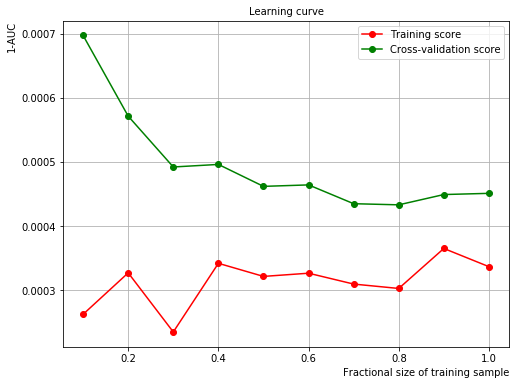

In [58]:
plt.figure(figsize=(8,6))
plt.title("Learning curve", fontsize=10)
plt.plot(trainpoints, learningcurveAUCs["train"], 'o-', color="r",
    label="Training score")
plt.plot(trainpoints, learningcurveAUCs["test"], 'o-', color="g",
    label="Cross-validation score")
plt.xlabel('Fractional size of training sample',horizontalalignment='right',x=1)
plt.ylabel("1-AUC",horizontalalignment='right',y=1)
plt.legend(loc="upper right")
plt.grid()
plt.savefig("results/learningcurve_opt_w06.png")
plt.show()

### Optimise hyperparameters

In [59]:
clf = getBDT()
!date
clf.fit(X_train,y_train, sample_weight = w_train)
!date
print("Trees used",clf.n_estimators_)

Tue Jul 23 09:06:34 CEST 2019
Tue Jul 23 09:15:33 CEST 2019
Trees used 250


In [62]:
#test = np.empty(len(self.method.estimators_))
test=[]
train = []
for pred in clf.staged_predict_proba(X_test):
    test.append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))
for pred in clf.staged_predict_proba(X_train):
    train.append(1.-roc_auc_score(y_train, pred[:,1], sample_weight=w_train))

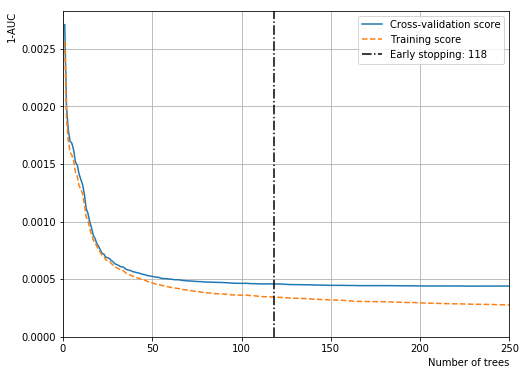

In [63]:
plt.figure(figsize=(8,6))
#plt.title("Number of trees = 250", fontsize=8)
x_trees=np.arange(1,251)
#print(x_trees)
plt.plot(x_trees,test,'-',label='Cross-validation score')
plt.plot(x_trees,train,'--',label='Training score')
axes=plt.gca()
plt.ylim([0,axes.get_ylim()[1]])
plt.xlim([0,250])
plt.plot([classifier.n_estimators_,classifier.n_estimators_],axes.get_ylim(),'-.',color="k",label="Early stopping: "+str(classifier.n_estimators_))
plt.plot()
plt.grid()
plt.legend(loc='best')
plt.xlabel("Number of trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC",horizontalalignment='right',y=1)
plt.show()

### Early stopping test

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.01, n_estimators=250,
                           n_iter_no_change=15, presort='auto', random_state=0,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)

In [35]:
for feature, importance in reversed(sorted(zip(features_names,clf_e.feature_importances_),key=lambda x: x[1])):
    print(feature,"\t", importance)

Coretrack_dRleadtrk 	 0.8335442786910728
Coretrack_pt 	 0.0448225218309473
Coretrack_nPiHits 	 0.040024932768829305
Coretrack_d0 	 0.03591911398589561
Coretrack_ratioptCalo 	 0.019474757514764237
Coretrack_nSiHoles 	 0.018769872730396805
Coretrack_dR 	 0.005866797030450321
Coretrack_z0 	 0.00157772544764362


In [32]:
#test = np.empty(len(self.method.estimators_))
test=[]
train = []
for pred in classifier.staged_predict_proba(X_test):
    test.append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))
for pred in classifier.staged_predict_proba(X_train):
    train.append(1.-roc_auc_score(y_train, pred[:,1], sample_weight=w_train))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

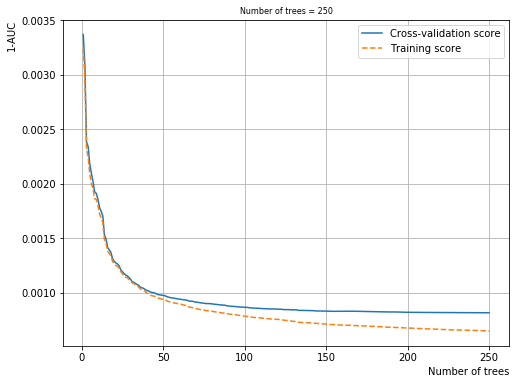

In [54]:
plt.figure(figsize=(8,6))
plt.title("Number of trees = 250", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
plt.plot(x_trees,test,'-',label='Cross-validation score')
plt.plot(x_trees,train,'--',label='Training score')
plt.grid()
plt.legend(loc='best')
plt.xlabel("Number of trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC",horizontalalignment='right',y=1)
plt.show()

### Optimise learining rate

In [17]:
learning_rates = [0.05,0.1,0.15,0.2,0.25]
learningratesAUCs = {}
for itrain in learning_rates:
    learningratesAUCs[itrain]=[]
    lr_clf=getBDT(options={"learning_rate":itrain})
    print("For learning_rate =",itrain,time.ctime(),end="")
    lr_clf.fit(X_train,y_train, sample_weight = w_train)
    print("-->",time.ctime())
    for pred in lr_clf.staged_predict_proba(X_test):
        learningratesAUCs[itrain].append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))

For learning_rate = 0.05 Tue Jul 23 05:31:33 2019--> Tue Jul 23 05:38:30 2019
For learning_rate = 0.1 Tue Jul 23 05:39:26 2019--> Tue Jul 23 05:46:28 2019
For learning_rate = 0.15 Tue Jul 23 05:47:24 2019--> Tue Jul 23 05:53:53 2019
For learning_rate = 0.2 Tue Jul 23 05:54:52 2019--> Tue Jul 23 06:01:25 2019
For learning_rate = 0.25 Tue Jul 23 06:02:21 2019--> Tue Jul 23 06:08:46 2019


In [22]:
dump(learningratesAUCs,"models/learningrates_newvars_w06.sav")
#learningratesAUCs=load("models/learningratesAUCs_w06.sav")

['models/learningrates_newvars_w06.sav']

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

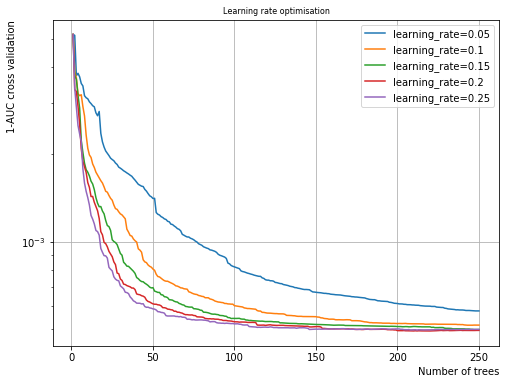

In [23]:
learning_rates = [0.05,0.1,0.15,0.2,0.25]
plt.figure(figsize=(8,6))
plt.title("Learning rate optimisation", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
for itrain in learning_rates:
    plt.plot(x_trees,learningratesAUCs[itrain],label='learning_rate='+str(itrain))
plt.grid()
plt.legend(loc='best')
plt.xlabel("Number of trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC cross validation",horizontalalignment='right',y=1)
plt.yscale('log')
plt.show()

### Optimise max depth

In [24]:
learning_depths = [2,3,4,5,6]
learningdepthsAUCs={}
for itrain in learning_depths:
    learningdepthsAUCs[itrain]=[]
    ld_clf=getBDT(options={"max_depth":itrain})
    print("For learning_rate =",itrain,time.ctime(),end="")
    ld_clf.fit(X_train,y_train, sample_weight = w_train)
    print("-->",time.ctime())
    for pred in ld_clf.staged_predict_proba(X_test):
        learningdepthsAUCs[itrain].append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))

For learning_rate = 2 Tue Jul 23 06:31:13 2019--> Tue Jul 23 06:34:08 2019
For learning_rate = 3 Tue Jul 23 06:35:03 2019--> Tue Jul 23 06:39:36 2019
For learning_rate = 4 Tue Jul 23 06:40:31 2019--> Tue Jul 23 06:46:22 2019
For learning_rate = 5 Tue Jul 23 06:47:17 2019--> Tue Jul 23 06:54:16 2019
For learning_rate = 6 Tue Jul 23 06:55:12 2019--> Tue Jul 23 07:03:10 2019


In [25]:
dump(learningdepthsAUCs,"models/learningdepths_newvars_w06.sav")
#learningdepthsAUCs=load("models/learningdepthsAUCs_w06.sav")

['models/learningdepths_newvars_w06.sav']

In [26]:
!date
learning_depths = [2,3,4,5,6]
plt.figure(figsize=(8,6))
plt.title("Depth optimisation", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
for itrain in learning_depths:
    plt.plot(x_trees,learningdepthsAUCs[itrain],label='max_depth='+str(itrain))
plt.grid()
plt.legend(loc='best')
plt.xlabel("Number of trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC cross validation",horizontalalignment='right',y=1)
#plt.ylim(0,0.005)
plt.yscale('log')
plt.show()

Tue Jul 23 07:04:08 CEST 2019
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 

### Trying mixed configurations

In [ ]:
learning_comb = {"learningr=0.13,depth=3"}


In [44]:
learning_depths = [2,3,4,5,6]
learningdepthsAUCs={}
for itrain in learning_depths:
    learningdepthsAUCs[itrain]=[]
    ld_clf=getBDT(options={"max_depth":itrain})
    print("For learning_rate =",itrain,time.ctime(),end="")
    ld_clf.fit(X_train,y_train, sample_weight = w_train)
    print("-->",time.ctime())
    for pred in ld_clf.staged_predict_proba(X_test):
        learningdepthsAUCs[itrain].append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))

For learning_rate = 2 Sun Jul  7 15:49:26 2019--> Sun Jul  7 15:51:46 2019
For learning_rate = 3 Sun Jul  7 15:52:26 2019--> Sun Jul  7 15:55:58 2019
For learning_rate = 4 Sun Jul  7 15:56:39 2019--> Sun Jul  7 16:01:13 2019
For learning_rate = 5 Sun Jul  7 16:01:55 2019--> Sun Jul  7 16:07:57 2019
For learning_rate = 6 Sun Jul  7 16:08:40 2019--> Sun Jul  7 16:15:30 2019


In [45]:
dump(learningdepthsAUCs,"models/learningdepthsAUCs_w06.sav")
#learningdepthsAUCS=load("models/learningdepthsAUCs_w06.sav")

['models/learningdepthsAUCs_w06.sav']

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

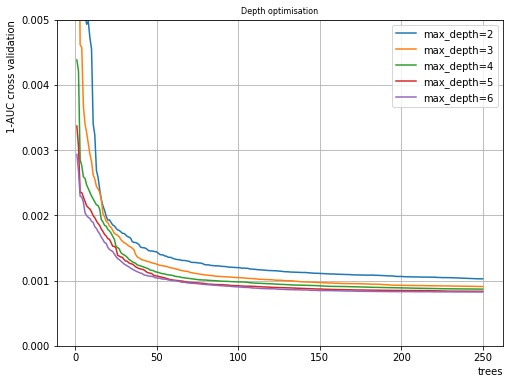

In [49]:
plt.figure(figsize=(8,6))
plt.title("Depth optimisation", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
for itrain in learning_depths:
    plt.plot(x_trees,learningdepthsAUCs[itrain],label='max_depth='+str(itrain))
plt.grid()
plt.legend(loc='best')
plt.xlabel("trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC cross validation",horizontalalignment='right',y=1)
plt.ylim(0,0.005)
plt.show()